
# 1. Simple Kalman Filter

Consider a simple robotic example, where we can estimate the position and velocity of a mobile robot equiped with a sensor capable of measuring only its position (e.g. GPS like signal).

The robot motion is constrained to the 2D plane. Therefore, we consider the state of the robot $${\bf x}_{k} = [ x, y, v_{x}, v_{y} ]^{T} $$ contains its position ($x, y$)  and velocity ($v_{x}, v_{y}$).

The state of the mobile robot evolves according to the following equation:

$${\bf x}_{k} = A {\bf x}_{k-1} + B {\bf u}_{k-1}$$

where:
- $A$ is the **state transition matrix**, defining how the state propagates over time.
- $B$ is the **control input matrix**, defining how external control inputs influence the system.

The state transition matrix is given by:
$$
A = \begin{bmatrix}
1 & 0 & \delta t & 0\\
0 & 1 & 0& \delta t\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & 1
\end{bmatrix}
$$
where $\delta t$ is the discrete time step.

This model says that position updates are based on velocity: $$ x_{k}=  x_{k-1} + v_x \delta t$$ and similarly for $y$.

The velocity remains unchanged unless acted upon by a control input which indicates that a constant velocity model is obtained if no commands ${\bf u}$ are given.

The control input ${u}_k$ affects the system through the control matrix $B$:
$$
B = \begin{bmatrix}
0 & 0 \\
0 & 0 \\
1 & 0 \\
0 & 1
\end{bmatrix}
$$

where

$$u_k = \begin{bmatrix} a_x \\ a_y \end{bmatrix}$$

with $a_x$ and $a_y$ representing accelerations in the $x$ and $y$ directions.

The control input directly modifies velocity:

  $$ v_{x_k} = v_{x_{k-1}} + a_x, \quad v_{y_k} = v_{y_{k-1}} + a_y$$


The robot measures its position acording to the following observation model:
$$ {\bf y}_{k} = C\:{\bf x}_{k} $$

where
$$
C = \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
\end{bmatrix}
$$

Those measurements can be

Your task is to finish implementing the Kalman Filter class to track the position of the robot over time.

### **Simulation Setup**



Now, the code sets up a simulation with the Kalman filter tracking a robot over time.

```python
dt = 0.1
time_steps = 100
process_noise = 3.0
measurement_noise = 0.01
```
- **`dt`**: Time step of 0.1 seconds.
- **`time_steps`**: The number of steps to simulate.
- **`process_noise`** and **`measurement_noise`**: The noise in the process and the measurements.

```python
true_state = np.array([0, 0, 1, 1])
kf = KalmanFilter(dt, process_noise, measurement_noise, initial_state=true_state.copy())
```
- **`true_state`**: The true initial state of the robot (starting at position `(0, 0)` with velocity `(1, 1)`).
- **`kf`**: An instance of the Kalman filter.

### **Control Input and Sensor Measurement Simulation**

When simulating this environment for SLAM we need to consider two main things:
- How to generate appropiate control to appropiate evolve the ground truth state?
- How to generate appropiate measurements of the (ground truth) state?

In both cases, we need to conder the __actual__ value and the __noisy__ value, which is typically modelled using Gaussian Noise:
- In the control case we consider ${\bf u} \sim \mathcal{N}(\hat{\bf u}, \sigma^2_{p})$, where $\hat{\bf u}$ is the true control command and $\sigma_{p}$ is the _process noise_ on the control.
- Similarily, we consider ${\bf y} \sim \mathcal{N}(\hat{\bf y}, \sigma^2_{m})$ where $\hat{\bf y}$ is the measurement of the true state and $\sigma_{m}$ is the _measurement noise_ that occurs as a result of imperfect sensor data.

### Task 1

In the simulation setup, we have provided two functions __generate_u__ and __generate_y__ that you __need to implement__ before implementing the Kalman Filter in the next step. These functions help up _simulate_ the scenario for this tutorial.

Both functions should return a tuple of size two, containing the generated value and the _noisy_ value. Gaussian noise can be added to any values using `np.random.normal`.


- **`generate_u`** should generate $\hat{\bf u}$ and ${\bf u}$ given the `process_noise` $\sigma_p$. While the control commands can represent any increments to the robots velocity, the simplement implementation is to provide increments of a constant value. Experiment with different control values and ensure that the robots trajectory behaves as expected.

- **`generate_y`** should generate $\hat{\bf y}$ and ${\bf y}$ given the robots __true__ state and the `measurement_noise` $\sigma_m$ . The noise simulates errors in sensor readings.

 > NOTE: Both functions should return a tuple of size two, containing the generated value and the _noisy_ value.

After implementing both functions, the main simulation loop should be able to run correctly. Comment out any Kalman Filter related functions and run the loop, generating a trajectory plot using the code provided.



Ensure that the trajectory looks correct, given your implementation of the __generate_u__ function.

### **Kalman Filter Class**

The `KalmanFilter` class is a model that tracks the state of a system (in this case, the position and velocity of the robot) over time, based on noisy measurements and control inputs.

```python
class KalmanFilter:
    def __init__(self, dt, process_noise, measurement_noise, initial_state):
```
- The constructor (`__init__`) initializes the Kalman filter parameters.
  - `dt`: Time step, how often we update the position.
  - `process_noise`: The noise in the system's movement (how unpredictable the motion model is is).
  - `measurement_noise`: The noise in the sensor measurements (how accurate the sensor is).
  - `initial_state`:  ${\bf x}_{0}$ ie. the initial position and velocity of the system.

```python
        self.A = np.array([[1, 0, dt, 0],
                           [0, 1, 0, dt],
                           [0, 0, 1, 0],
                           [0, 0, 0, 1]])
```
- `A` is the **state transition matrix**. It describes how the state (position and velocity) evolves over time. The robot's position and velocity should be updated by this matrix in each step.
  - The 4x4 matrix is set up so that the position updates by adding velocity times the time step (`dt`).

```python
        self.B = np.array([[0, 0],
                           [0, 0],
                           [1, 0],
                           [0, 1]])
```
- `B` is the **control matrix**, which determines how the control inputs (`u`) affect the state. The inputs might be velocity commands or accelerations that change the state. In this case we model `u` as providing delta increments to the robots velocity

```python
        self.H = np.array([[1, 0, 0, 0],
                           [0, 1, 0, 0]])
```
- `H` is the **measurement matrix**, which defines how the sensor measurements are related to the state.

- `Q` is the **process noise covariance**, which models how unpredictable the system's movement is (i.e., how much we trust the system model).
- `R` is the **measurement noise covariance**, representing the uncertainty in the sensor measurements.
In your case you will need to construct `H`, `Q` and `R` appropiately

```python
        self.P = np.eye(4) * 1.0
        self.x = initial_state
```
- `P` is the **estimate covariance matrix**, which describes how confident we are in the current estimate of the state.
- `x` is the **initial state vector** that contains the initial position and velocity of the robot.

### **Kalman Filter Methods**

### Task 2

You need to implement the __predict__ and __update__ methods of the Kalman Filter.

At each intermediate step (ie, after predicting but before implementing the update) you should plot your estimated trajectory (some of the provided code will need to be modified) and _compare_ it with the ground truth trajectory. Additionally:

After implementing the __predict__ function:
- Plot the covariance matrix (code provided) of the robots position at each timestep. Without any measurements to correct its poisition, the covariance ellipse should grow over time.
- Experiment with different _control inputs_ and _process noise_ values. How does this effect the prediction of your robot state? Consider how the covariance of the robot state should change with different process noise values.

For example, when $\sigma_p$ = 1.0 and some constant control commands the estimated trajectory may look like

<br>![Text](https://canvas.sydney.edu.au/files/42225874/download?download_frd=1)

> NOTE: covarinace plots has been disabled for this example

After implementing the __update__ function:
- Compare your prediction only trajectory with the trajectory when measurement updates are applied. Hopefully, the latter should be more accurate - how can you quantify this accuracy?
- Experiment with different _measurement noise_ values and see how this effects the resulting estimation.
- Experiment with updating the Kalman Filter with new measurements at different rates, simulating a sensor with a slow update rate. What happens to the estimated mean and covariance? When a measurement update occurs what should happen to the estimated covariance?

Similarily, when updates are applied to the Kalman Filter (with  $\sigma_m$ = 0.01) we see the trajectory more accurately aligns with the ground truth.

<br>![Text](https://canvas.sydney.edu.au/files/42225883/download?download_frd=1)

> NOTE: covarinace plots has been disabled for this example


In both functions `self.x` and `self.P` will need to updated to reflect the new state mean and covariance.

In addition to plotting and analysing robots position, ensure to visualise and validate the estimate of your states _velocity_. Since you do not not take measurements of this directly, you rely on the accuracy of your robots motion model update. How you do this is up to you but we recommend:
- Plotting the velocity overtime.
- Compare your estimate with the ground truth as you would with the robots position.





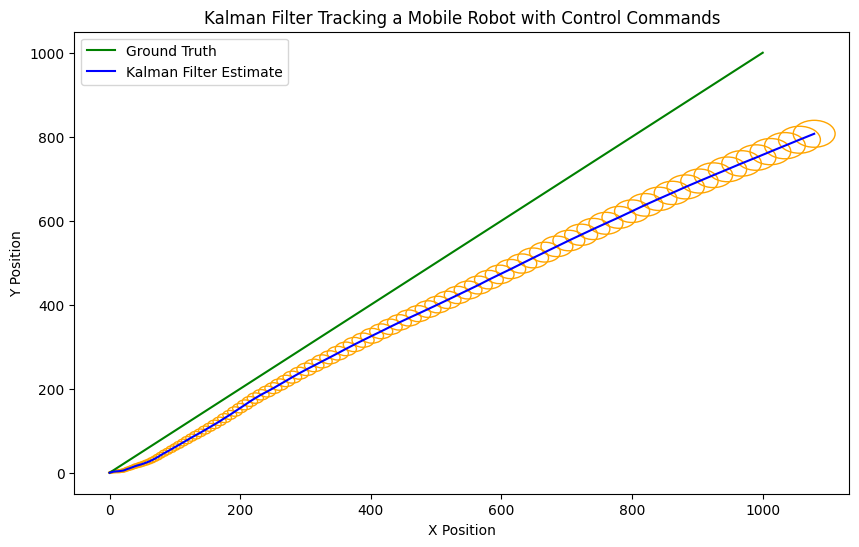

In [28]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.axes import Axes

def plot_position_covariance(axes: Axes, position: np.ndarray, position_covariance: np.ndarray):
  from matplotlib import patches
  w, v = np.linalg.eigh(position_covariance)
  k = 0.5
  x, y = position

  angle = np.arctan2(v[1, 0], v[0, 0])
  e1 = patches.Ellipse((x, y),
                          np.sqrt(w[0]),
                          np.sqrt(w[1]),
                          angle=np.rad2deg(angle),
                          fill=False,
                          color='orange')
  axes.add_artist(e1)
  return e1



class KalmanFilter:
    def __init__(self, dt, process_noise, measurement_noise, initial_state):
        self.dt = dt
        self.A = np.array([[1, 0, dt, 0],
                           [0, 1, 0, dt],
                           [0, 0, 1, 0],
                           [0, 0, 0, 1]])
        
        self.B = np.array([[0, 0],
                           [0, 0],
                           [1, 0],
                           [0, 1]])
        
        self.H = np.array([[1, 0, 0, 0],
                           [0, 1, 0, 0]])

        self.Q = process_noise**2 * (np.array([[1, 0, 0, 0],
                                                [0, 1, 0, 0],
                                                [0, 0, 1, 0],
                                                [0, 0, 0, 1]]))

        self.R = np.array([[measurement_noise**2, 0],
                           [0, measurement_noise**2]])

        self.P = np.eye(4) * 1.0
        self.x = initial_state

    def predict(self, u):
        
        self.x = self.A @ self.x + self.B @ u
        self.P = self.A @ self.P @ self.A.T + self.Q

        return self.x

    def update(self, z):
        
        S = self.H @ self.P @ self.H.T + self.R
        y = z - self.H @ self.x

        K = self.P @ self.H.T @ np.linalg.inv(S)

        self.x = self.x + K @ y
        self.P = (np.eye(4) - K @ self.H) @ self.P


        return self.x

# Simulation parameters
dt = 0.1
time_steps = 100
process_noise = 3.0
measurement_noise = 0.01

# Initial state [x, y, vx, vy]
true_state = np.array([[0], [0], [1], [1]])
kf = KalmanFilter(dt, process_noise, measurement_noise, initial_state=true_state.copy())

# Ground truth trajectory
true_trajectory = []
predicted_trajectory = []
measured_positions = []
estimated_position_covariance = []

def generate_u(process_noise: float):
    
    u = np.array([[2.0], 
                  [2.0]]) 

    # Addition of Gaussian noise with mean = 0 and standard deviation = process noise 
    u_noisy = u + np.random.normal(0, process_noise, size=(2,1))

    return u, u_noisy

def generate_y(x_true: np.ndarray, measurement_noise: float):
    
    # Extracting positions from state vector 
    y = x_true[:2]

    y_noisy = y + np.random.normal(0, measurement_noise)

    return y, y_noisy

time = np.arange(time_steps) * dt

np.random.seed(42)
for t in range(time_steps):
    # control input
    u, u_noisy = generate_u(process_noise)

    # simulation prediction
    true_state = kf.A @ true_state + kf.B @ u

    # measurement of position
    y, y_noisy = generate_y(true_state, measurement_noise)

    predicted_state = kf.predict(u_noisy)
    # measured_state = kf.update(y_noisy)

    #TODO after prediction step

    #add measurements to the kalman filter at different rates and compare with the prediction only solution
    estimated_position_covariance.append(kf.P[:2, :2])
    estimated_position_covariance.append(kf.P[:2, :2])
    true_trajectory.append(true_state[:2])
    predicted_trajectory.append(predicted_state[:2])
    measured_positions.append(measured_state[:2])


true_trajectory = np.array(true_trajectory)
predicted_trajectory = np.array(predicted_trajectory)
measured_positions = np.array(measured_positions)
estimated_position_covariance = np.array(estimated_position_covariance)

# plotting
# change as required!

fig = plt.figure(figsize=(10, 6))
ax = fig.gca()

for cov, pos in zip(estimated_position_covariance, predicted_trajectory):
  plot_position_covariance(ax, pos, cov)

# Plot results
ax.plot(true_trajectory[:, 0], true_trajectory[:, 1], 'g-', label='Ground Truth')
# ax.plot(measured_positions[:, 0], measured_positions[:, 1], 'rx', label='Measurements (Noisy)')
ax.plot(predicted_trajectory[:, 0], predicted_trajectory[:, 1], 'b-', label='Kalman Filter Estimate')
ax.legend()
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_title('Kalman Filter Tracking a Mobile Robot with Control Commands')

plt.show()